# Import modules

In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import datetime
import shutil
import time
import os
from pathlib import Path

#tensorflow library for building model

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers

from tensorflow.keras import utils
from tensorflow.keras import applications
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.callbacks import LearningRateScheduler





#for preprocessing
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator


In [7]:
import keras as tf
print(tf.__version__)

2.4.3


# Simple model 

This model depend only on one feature which is the brightness of picture based on a threshold if its greater than it it will be day else its night 

In [2]:
path = Path('dataset/')

In [4]:
train_day = list((path/'train/day').iterdir())
train_night = list((path/'train/night').iterdir())
test_day = list((path/'test/day').iterdir())
test_night = list((path/'test/night').iterdir())

In [5]:
#2 lists to store brightness for 2 classes
day_brightness = []
night_brightness = []

for file in train_day:
  img = cv2.imread(str(file)) # read img 
  img = cv2.resize(img, (500, 500)) # resize image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert to hsv
  avg_brightness = np.mean(img[:, :, 2]) # calculate average value of Value channel from HSV image
  day_brightness.append(avg_brightness) # appending to array

for file in train_night:
  img = cv2.imread(str(file)) # reading img 
  img = cv2.resize(img, (600, 600)) # resizing image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # converting to hsv
  avg_brightness = np.mean(img[:, :, 2]) # calculating average value of Value channel from HSV image
  night_brightness.append(avg_brightness) # appending to array

In [6]:
# calculating average brightness
day_avg_brightness = np.mean(day_brightness)
night_avg_brightness = np.mean(night_brightness)
day_avg_brightness,night_avg_brightness

(115.13188236350783, 34.80292741176105)

# visualize threshold

Text(0.5, 1.0, 'Night')

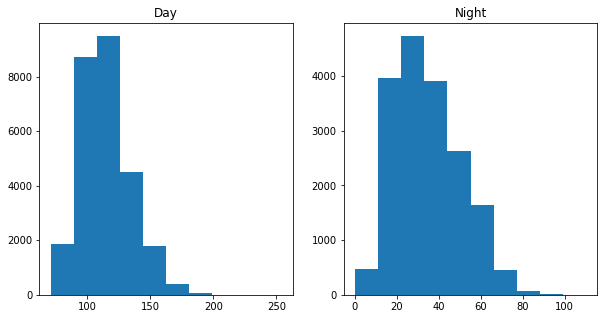

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(day_brightness)
ax[0].set_title('Day')
ax[1].hist(night_brightness)
ax[1].set_title('Night')

# choose threshold around 95

In [8]:
def test(thresh=93):

  num_corrects = 0 
  total = len(test_day) + len(test_night) # total number of images in validaton set

  for file in test_day:
    img = cv2.imread(str(file)) 
    img = cv2.resize(img, (600,600)) # resize image to standard size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert to HSV
    avg_brightness = np.mean(img[:, :, 2]) # calculate average  
    if avg_brightness > thresh:
      num_corrects += 1 
    
  for file in test_night:
    img = cv2.imread(str(file)) 
    img = cv2.resize(img, (600,600)) # resize image to standard size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert to HSV
    avg_brightness = np.mean(img[:, :, 2]) # calculate average 
    if avg_brightness < thresh:
      num_corrects += 1
  
  accuracy = (num_corrects * 100)/total # calculating percentage of correctly classified images
  return accuracy

In [9]:
test()

93.49254353947231

#### 93.49 accuracy for simple model 

# Deep neural network 

## Global Variables

In [3]:
SEED = 91
SHUFFLE = True
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
VAL_SPLIT_RATIO = 0.15
DATASET_PATH="dataset"
SAVE_PATH="dataset"

## Visualize the dataset

* Data Distribution

Text(0.5, 1.0, 'Data distribution')

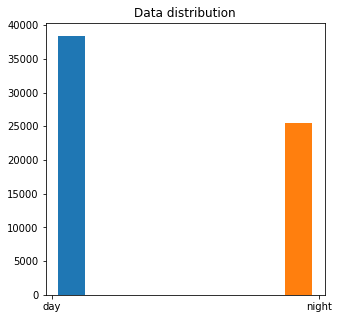

In [34]:
cls_count=[]
count=0

fig, ax = plt.subplots(1,1,figsize=(5,5))
for cls in os.listdir(DATASET_PATH):
    x=[cls  for s in os.listdir(os.path.join(DATASET_PATH+"\\"+cls))]
    cls_count.append(x)
    
ax.hist(cls_count,bins=4)
ax.set_title('Data distribution')

In [11]:
def plot_batch(X, Y=None, figSize=(20, 20), dpi=75, cells_per_col=4, color=None,BATCH_SIZE=16):
    
    random_ids = (np.random.randint(0, len(X) ,BATCH_SIZE ))
    m = len(random_ids)  # length of the batch
    fig = plt.figure(figsize=figSize, dpi=dpi)  
    for i in range(m):  # for each img in the batch
        img = cv2.imread(X[random_ids[i]])
        axis = fig.add_subplot(round(m/cells_per_col), cells_per_col, i+1) # display a grid of subplots
        plt.imshow(img)                   

        if Y is not None:
            class_id = Y[random_ids[i]] 
            axis.set_title("class-name: " + str(class_id))
    fig.tight_layout(pad=1.5)
    plt.show()

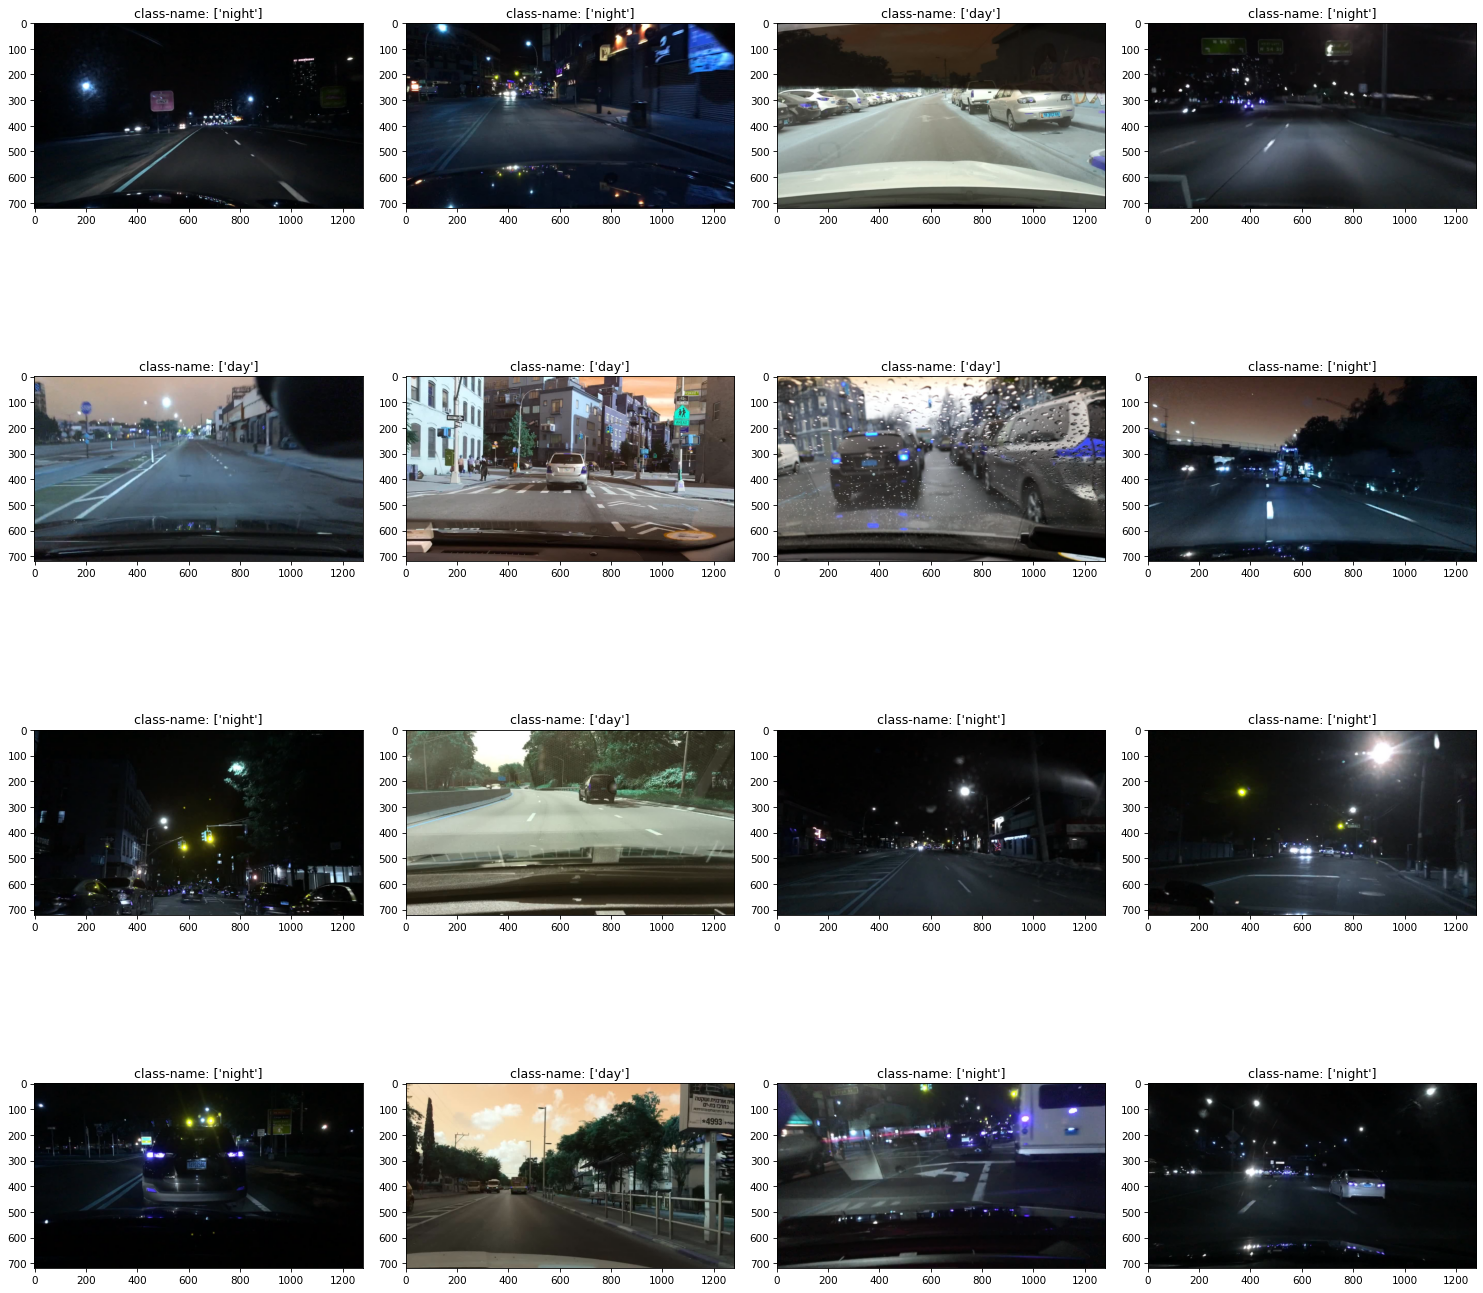

In [12]:
day_names = os.listdir(DATASET_PATH+"\\day")
day_names=[DATASET_PATH + "\\day\\" + s  for s in day_names]
day_labels=list(np.full((len(day_names), 1), "day"))

night_names=os.listdir(DATASET_PATH+"\\night")
night_names=[DATASET_PATH +"\\night\\"  +s  for s in night_names]
night_labels=list(np.full((len(night_names), 1), "night"))

image_Names=day_names+night_names
image_labels=day_labels+night_labels


plot_batch(image_Names,image_labels)


# Data Preparation 


#### Split into train and test

In [ ]:
classes_dir = ['day', 'night']
direc=["train","test","val"]    

test_ratio = 0.15
val_ratio = 0.15

for i in direc:
    i = os.path.join(DATASET_PATH, i)
    os.mkdir(i)
    
    day = os.path.join(i, 'day')
    os.mkdir(day)

    night = os.path.join(i, 'night')
    os.mkdir(night)


for cls in classes_dir:
        
    src = DATASET_PATH +"\\"+cls # Folder to copy images from
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames =  np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                      int(len(allFileNames)* (1 - test_ratio))])

    
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ',cls, len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    for name in train_FileNames:
        shutil.copy(name, (DATASET_PATH +"//"+'train' + "//"+cls))
    for name in test_FileNames:
        shutil.copy(name,( DATASET_PATH +"//"+'test' +"//" +cls))
    for name in val_FileNames:
        shutil.copy(name,( DATASET_PATH +"//"+'val' +"//" +cls))


## Load dataset and preprocessing



In [4]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_set = datagen.flow_from_directory(DATASET_PATH + "//train",
                                           target_size=(600, 600),
                                           batch_size=32,
                                           shuffle=True,
                                           color_mode="rgb",
                                           class_mode='binary')

test_set = datagen.flow_from_directory( DATASET_PATH + "//test",
                                        target_size=(600, 600),
                                        batch_size=32,
                                        shuffle=True,
                                        color_mode="rgb",
                                        class_mode='binary')


val_set = datagen.flow_from_directory(DATASET_PATH + "//val",
                                      target_size=(600, 600),
                                      batch_size=32,
                                      shuffle=True,
                                      color_mode="rgb",
                                      class_mode='binary')


Found 44742 images belonging to 2 classes.
Found 9589 images belonging to 2 classes.
Found 9587 images belonging to 2 classes.


## Build Model

In [5]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3),input_shape=(600, 600, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), padding='same')) 
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=128, activation='elu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3), 
    loss="binary_crossentropy", 
    metrics=["accuracy"])
    
    return model
    

### Define callbacks

In [6]:
early_stop = callbacks.EarlyStopping(patience=10, monitor="val_loss")

checkpoint = callbacks.ModelCheckpoint(
    SAVE_PATH+"/model_checkpoints/cp-{epoch:04d}.ckpt", 
    save_best_only=True, 
    save_weights_only=True,
    verbose=1, 
    monitor="val_accuracy", 
    mode="auto",
)

lr_sched = callbacks.ReduceLROnPlateau(
    factor=0.9, patience = 50, 
    min_lr=1e-5, monitor="val_loss",
    mode="auto", verbose=0
)
tensorboard = callbacks.TensorBoard(
    SAVE_PATH+"/model_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    update_freq=1
)


## Fit model

In [7]:
My_model=create_model()
t1 = time.perf_counter()
model_history = My_model.fit(
    train_set, 
    epochs=80,
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    validation_data=val_set,
    steps_per_epoch=8,
    callbacks=[early_stop, checkpoint, lr_sched, tensorboard]
)
t2 = time.perf_counter()
print(f"training took {(t2-t1)/60:.2f} min")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 598, 598, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 598, 598, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 299, 299, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 299, 299, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 32)      9

Epoch 20/80
8/8 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9648
Epoch 00020: val_accuracy did not improve from 0.98707
8/8 [==============================] - 407s 51s/step - loss: 0.1133 - accuracy: 0.9648 - val_loss: 0.1246 - val_accuracy: 0.9739
Epoch 21/80
8/8 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9883
Epoch 00021: val_accuracy did not improve from 0.98707
8/8 [==============================] - 412s 52s/step - loss: 0.0533 - accuracy: 0.9883 - val_loss: 0.0779 - val_accuracy: 0.9778
Epoch 22/80
8/8 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9805
Epoch 00022: val_accuracy improved from 0.98707 to 0.99020, saving model to dataset/model_checkpoints\cp-0022.ckpt
8/8 [==============================] - 397s 50s/step - loss: 0.0749 - accuracy: 0.9805 - val_loss: 0.0602 - val_accuracy: 0.9902
Epoch 23/80
8/8 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9961
Epoch 00023: val

Epoch 48/80
8/8 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9961
Epoch 00048: val_accuracy did not improve from 0.99875
8/8 [==============================] - 379s 47s/step - loss: 0.0195 - accuracy: 0.9961 - val_loss: 0.0100 - val_accuracy: 0.9983
Epoch 49/80
8/8 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9961
Epoch 00049: val_accuracy did not improve from 0.99875
8/8 [==============================] - 379s 47s/step - loss: 0.0124 - accuracy: 0.9961 - val_loss: 0.0155 - val_accuracy: 0.9955
Epoch 50/80
8/8 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9961
Epoch 00050: val_accuracy did not improve from 0.99875
8/8 [==============================] - 379s 47s/step - loss: 0.0086 - accuracy: 0.9961 - val_loss: 0.0188 - val_accuracy: 0.9945
Epoch 51/80
8/8 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9922
Epoch 00051: val_accuracy improved from 0.99875 to 0.99885, saving model to 

## Plot loss history

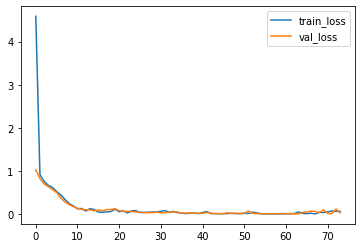

In [8]:
plt.plot(model_history.history["loss"], label="train_loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.legend()

## Save the model into tf file and the history to a csv file

In [14]:
tf.keras.models.save_model(
        My_model, DATASET_PATH)

hist_df = pd.DataFrame(model_history.history) 
# save history to csv: 
hist_csv_file = DATASET_PATH+'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

INFO:tensorflow:Assets written to: dataset\assets


## Testing model

In [16]:
#load model from checkpoint
latest = tf.train.latest_checkpoint(DATASET_PATH+"\\model_checkpoints")
loaded_model=create_model()
loaded_model.load_weights(latest)
loss, acc = loaded_model.evaluate(test_set, verbose=0)
print("Restored model testing, accuracy: {:5.2f}%".format(100 * acc))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 598, 598, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 598, 598, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 299, 299, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 299, 299, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 299, 299, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 149, 149, 32)     